In [1]:
import numpy as np

In [ ]:
# def removeRandom(a, n, pvals=None):
        
#     """Removes n people from random cells in a, while making sure no cell 
#     goes below 0. 
    
#     n should be a non-negative integer. If it is negative, we take np.abs(n) and continue.
    
#     pvals allows to specify the probability of each cell to 
#     receive people. pvals has to be the same size as a. If pvals is not set, 
#     equal probablity for each cell is assumed."""
        
#     if 'pvals' not in locals():
#         pvals = np.array([1/a.size]*a.size)
    
#     # make sure n is a positive number:
#     n = np.abs(n)
    
#     c = np.cumsum(np.r_[0, a])
#     if n < c[-1]:
#         print("c:")
#         print(c)
#         print(" ")
#         print("(np.arange(c[-1]) + 1):") 
#         print(np.arange(c[-1]) + 1)
#         print(" ")
# #         print(pvals.size)
#         r = np.random.choice(np.arange(c[-1]) + 1, n, replace = False, p = pvals)
#         print("r:")
#         print(r)
#         print(" ")
#         print("r[:,None]")
#         print(r[:,None])
#         print(" ")
#         print("c[None,:]")
#         print(c[None,:])
#         print(" ")
#         print("r[:,None] <= c[None,:]")
#         print(r[:,None] <= c[None,:])
#         print(" ")
#         d = np.sum(r[:,None] <= c[None,:], axis=0)
#         print("d")
#         print(d)
#         print(" ")
#         print("c-d")
#         print(c-d)
#         print(" ")
#         print("np.diff(c-d)")
#         print(np.diff(c-d))
#         return np.diff(c-d)
#     else:
#         return np.zeros_like(a)

In [ ]:
# a = np.array([5,8,3,7])
# n = 2
# print(removeRandom(a,n))

Ergo: There is IMO no way to assign probabilities to the cells when it comes to removing people with this approach. See also my comment at https://stackoverflow.com/questions/43225076/iteratively-subtract-values-in-array

# Speed test:

In [ ]:
def removeRandomA(x, n):   
    # work on a copy, don't modify the original array in-place:
    a = np.copy(x)
    
    c = np.cumsum(np.r_[0, a])
    if n < c[-1]:
        r = np.random.choice(np.arange(c[-1]) + 1, n, replace = False)
        d = np.sum(r[:,None] <= c[None,:], axis=0)
        return np.diff(c-d)
    else:
        return np.zeros_like(a)

This one is not very elegant, and tends to get stuck in the loop:

In [ ]:
def removeRandomB(x, n, pvals=None):
    # work on a copy, don't modify the original array in-place:
    a = np.copy(x)
    
    if n < np.sum(a):
        aranged = np.arange(a.size)
        randomIndexes = np.random.choice(aranged, n, p=pvals)
        np.subtract.at(a, randomIndexes, 1)

        while(a[a < 0].size > 0):
            print(a)
        
            # what's the sum of all cells below 0?
            sumBelowZero = np.abs(np.sum(a[a < 0]))            
            # set them to 0
            a[a < 0] = 0   
            
            # now look at all cells > 0 and remove from them, while maintaining the pvals for those
            randomIndexes = np.random.choice(aranged, n, p=pvals)

            np.subtract.at(a, randomIndexes, 1)
        return a
    else:
        return np.zeros_like(a)

This next one is an attempt to optimize ```removeRandomB()``` as defined above by reducing the chance that population is removed from cells that are already 0, setting their pval to 0.

In [ ]:
def removeHelper(a, aranged, n, pvals):
    # set the pvals to 0 at cells that are already 0   
    print("Pvals: "+str(pvals))
    pvals[a == 0] = 0

    # now we have to re-normalize the pvals, so that they sum up to 1.0
    pvals = np.divide(pvals.astype(np.float64), np.sum(pvals))

    randomIndexes = np.random.choice(aranged, n, p=pvals)
    np.subtract.at(a, randomIndexes, 1)
    return a



def removeRandomC(x, n, pvals=None):
    
    if n < np.sum(x):
        # work on a copy, don't modify the original array in-place:
        a = np.copy(x)
        
        aranged = np.arange(a.size)
        
        # initial run before we go into the loop
        a = removeHelper(a, aranged, n, pvals)
        
        while(a[a < 0].size > 0):
            print(a)
        
            # what's the sum of all cells below 0?
            sumBelowZero = np.abs(np.sum(a[a < 0]))            
            # set them to 0
            a[a < 0] = 0   
            
            # randomly remove people
            a = removeHelper(a, aranged, n, pvals)
            
        return a
    else: 
        print("Warning: trying to remove more people than we have in the raster")
        return np.zeros_like(a)

Suggestion from https://stackoverflow.com/questions/51880957/numpy-reduce-the-sum-of-an-array-by-n:

In [2]:
def removeRandomD(array, total, probs=None):
    if total >= np.sum(array):
        return np.zeros_like(array)

    to_remove = total

    while to_remove != 0:
        idx = np.random.choice(range(len(array)), p=probs)

        removeable = min(array[idx], to_remove)

        array[idx] = array[idx] - removeable
        to_remove = to_remove - removeable

    return array

In [3]:
x = np.random.randint(5, size=5)
pvals = np.array([0.1,0.1,0.2,0.3,0.3])

summ = np.sum(x)
rrr  = int(summ*0.3) # remove 50%

print(summ)
print(rrr)

8
2


In [4]:
a = removeRandomD(x, rrr, pvals)
print(a)

[0 2 3 1 0]


Check whether the ```pval``` works correctly:

In [13]:
x = np.array([3,6,8,2])
rrr = 10
pvals = np.array([0.0,0.0,0.5,0.5])
o = removeRandomD(x, rrr, pvals)
print(o)

[3 6 0 0]


In [58]:
import pandas as pd

timings = []

array_sizes = [10, 100, 1000, 10000]
array_maxes = [10, 100, 1000, 10000]
remove_percentages = [0.1, 0.2, 0.3, 0.4]  # 10%, 20%, ...

for array_size in array_sizes:
    for array_max in array_maxes:
        for remove_percentage in remove_percentages:

            x = np.random.randint(array_max, size=array_size)                        

            summ = np.sum(x)
            rrr  = int(summ*remove_percentage) 
            
            t =  %timeit -o -r 2 -n 2 removeRandomD(x, rrr)

            timings.append((array_size, array_max, remove_percentage*100, t.best))
                        
            print(" ")
        
        print(" = ")

30.3 µs ± 2.83 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
27.3 µs ± 4.27 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
50.4 µs ± 10.6 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
The slowest run took 4.49 times longer than the fastest. This could mean that an intermediate result is being cached.
37.4 µs ± 23.8 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
 = 
36.6 µs ± 10.7 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
29.1 µs ± 6.84 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
43.5 µs ± 6.15 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
The slowest run took 7.26 times longer than the fastest. This could mean that an intermediate result is being cached.
50.1 µs ± 38 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
 = 
22.7 µs ± 7.1 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
49.6 µs ± 5.01 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
 
64.5 µs ± 21.9 µs per loop (mean ± std.

In [59]:
timings = pd.DataFrame(timings, columns=['array_size','array_max','remove_percent','seconds'])
timings

,array_size,array_max,remove_percent,seconds
0,10,10,10.0,0.000027
1,10,10,20.0,0.000023
2,10,10,30.0,0.000040
3,10,10,40.0,0.000014
4,10,100,10.0,0.000026
5,10,100,20.0,0.000022
6,10,100,30.0,0.000037
7,10,100,40.0,0.000012
8,10,1000,10.0,0.000016
9,10,1000,20.0,0.000045


Let's check visually which factor plays the biggest role:

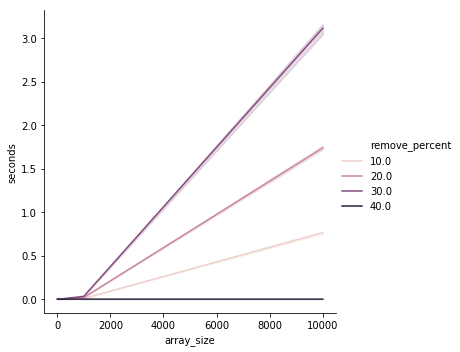

In [60]:
import seaborn as sns

#g = sns.FacetGrid(timings, row='array_size', col='array_max')
#g.map(sns.relplot, kind="line", x=timings.remove_percent, y=timings.seconds)

sns.relplot(data=timings, kind="line", x="array_size", y="seconds", hue="remove_percent")

# 💥 TODO

Try out some of the tricks in **[How to get embarrassingly fast random subset sampling with Python](https://medium.freecodecamp.org/how-to-get-embarrassingly-fast-random-subset-sampling-with-python-da9b27d494d9)**

For the record, here's how to time a function with different variables and store the ```%timeit``` values for plotting etc. Based on https://stackoverflow.com/questions/48205956/ipython-how-to-save-timeit-values-for-each-iteration. See also https://ipython.org/ipython-doc/2/api/generated/IPython.core.magics.execution.html for an overview of the attributes of the different TimeitResult objects.

⚡️ **Warning!** The cell below will run for several hours...

In [ ]:
timingsA = []
timingsB = []

array_sizes = [10, 100, 1000, 10000]
array_maxes = [10, 100, 1000, 10000]
remove_percentages = [0.1, 0.2, 0.3, 0.4]  # 10%, 20%, ...

for array_size in array_sizes:
    for array_max in array_maxes:
        for remove_percentage in remove_percentages:

            x = np.random.randint(array_max, size=array_size)                        

            summ = np.sum(x)
            rrr  = int(summ*remove_percentage) # remove 20%
            
            t =  %timeit -o -r 5 -n 10 removeRandomA(x, rrr)
#            foo =  %time removeRandomA(x, rrr)
            timingsA.append((array_size, array_max, remove_percentage, t))
            
            t =  %timeit -o -r 5 -n 10 removeRandomB(x, rrr)
#            foo =  %time removeRandomB(x, rrr)
            timingsB.append((array_size, array_max, remove_percentage, t))
            
            print(" ")
        
        print(" = ")

In [ ]:
for a, b in zip(timingsA, timingsB):
    print(a)
    print(b)